In [27]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import caiman as cm
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style("white")
%load_ext autoreload
%autoreload 2
%matplotlib inline
fish_path = os.path.abspath(os.path.join('..'))
if fish_path not in sys.path:
    sys.path.append(fish_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Load data

In [2]:
imgStack = np.load('imgDMotion.npy')
Y = np.asarray(imgStack)
Y = Y.transpose([1,2,0])

## 2. Detrend raw signal on pixels

### 2.1 Temporal downsampling
This could be set later in the code using pre_svd.svd_patch
```python
import spatialDenoising.preprocess_blockSVD as pre_svd
ts = 5
Y_rm = pre_svd.temporal_decimation(Y_rm.T,ts).T
```

### 2.2 Remove outliers (artifacts -- skip for this analysis)
#### check in time if there any drop or jump of the signal

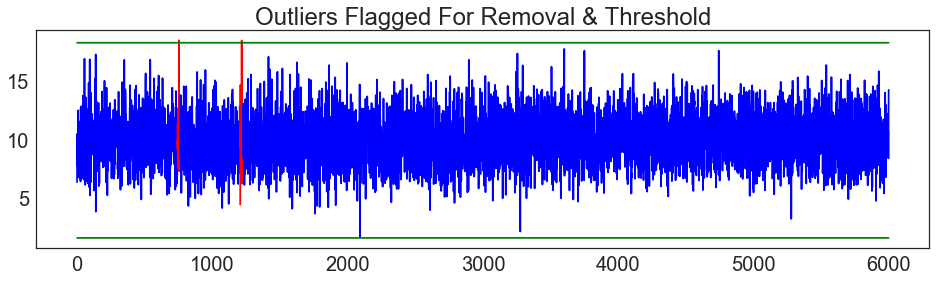

In [3]:
from spatialDenoising.preprocess import flag_outliers
outlier_idx, disc_idx = flag_outliers(Y[100, 200], thresh_stdv=4, buffer=10, visualize=True)

#### remove outliers

In [4]:
# mov = np.delete(Y[100, 200], outlier_idx, axis=-1)

### 2.3 Detrend movie at pixel level -- skip this

In [5]:
from spatialDenoising.preprocess import detrend # default order = 3
stim = None
disc = None
Y_detr, trend, _, _ = detrend(Y, stim, disc) # this could be speed up using mp....

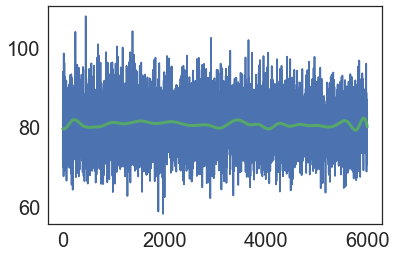

In [6]:
plt.plot(Y[90, 100, :])
plt.plot(trend[90, 100, :], linewidth=3)
plt.show()

In [7]:
np.save('Y_detr', Y_detr)
np.save('Y_trend', trend)

### 3.1 Spatial wiener filter smooth over a boxed neighbour with half length gHalf

In [8]:
from spatialDenoising.denoise import spatial as spatialWF
# neighbors
k = 4
gHalf = np.array([k,k]) // 2

In [9]:
%%time
Y_wf = spatialWF(Y,gHalf=gHalf)

first k pixels 0
first k pixels 1000
first k pixels 2000
first k pixels 3000
first k pixels 4000
first k pixels 5000
first k pixels 6000
first k pixels 7000
first k pixels 8000
first k pixels 9000
first k pixels 10000
first k pixels 11000
first k pixels 12000
first k pixels 13000
first k pixels 14000
first k pixels 15000
first k pixels 16000
first k pixels 17000
first k pixels 18000
first k pixels 19000
first k pixels 20000
first k pixels 21000
first k pixels 22000
first k pixels 23000
first k pixels 24000
first k pixels 25000
first k pixels 26000
first k pixels 27000
first k pixels 28000
first k pixels 29000
first k pixels 30000
first k pixels 31000
first k pixels 32000
first k pixels 33000
first k pixels 34000
first k pixels 35000
first k pixels 36000
first k pixels 37000
first k pixels 38000
first k pixels 39000
first k pixels 40000
first k pixels 41000
first k pixels 42000
first k pixels 43000
first k pixels 44000
first k pixels 45000
first k pixels 46000
first k pixels 47000
first

In [10]:
np.save('Y_wf', Y_wf)

### 3.2 Spatial denoising using patched SVD (Greedy algorithm)

In [11]:
from spatialDenoising.denoise import temporal as svd_patch
nblocks=[12,12]
dx=4
maxlag=5
confidence=0.99
greedy=False,
fudge_factor=1
mean_th_factor=1.15
U_update=False
min_rank=1
stim_knots=None
stim_delta=0

In [12]:
%%time
Y_svd, ranks = svd_patch(Y, nblocks=nblocks, dx=dx, stim_knots=stim_knots, stim_delta=stim_delta)

	M	rank: 2	run_time: 16.975918
	M	rank: 1	run_time: 20.372191
	M	rank: 1	run_time: 20.774792
	M	rank: 2	run_time: 20.539789
	M	rank: 2	run_time: 20.442348
	M	rank: 1	run_time: 21.553185
	M	rank: 2	run_time: 21.155419
	M	rank: 2	run_time: 24.000829
	M	rank: 1	run_time: 25.983660
	M	rank: 1	run_time: 25.297400
	M	rank: 2	run_time: 24.648624
	M	rank: 2	run_time: 23.786188
	M	rank: 1	run_time: 28.941778
	M	rank: 1	run_time: 24.746515
	M	rank: 1	run_time: 26.603014
	M	rank: 2	run_time: 26.405848
	M	rank: 1	run_time: 28.149507
	M	rank: 2	run_time: 26.035135
	M	rank: 2	run_time: 28.839861
	M	rank: 2	run_time: 25.627445
	M	rank: 2	run_time: 28.221215
	M	rank: 1	run_time: 27.649102
	M	rank: 2	run_time: 24.748107
	M	rank: 2	run_time: 32.951786
	M	rank: 2	run_time: 32.079596
	M	rank: 2	run_time: 34.507755
	M	rank: 2	run_time: 23.685749
	M	rank: 2	run_time: 26.264052
	M	rank: 2	run_time: 29.408821
	M	rank: 1	run_time: 28.665272
	M	rank: 2	run_time: 30.279558
	M	rank: 1	run_time: 30.626382
	M	rank:

	M	rank: 2	run_time: 19.998943
	M	rank: 2	run_time: 17.683937
	M	rank: 2	run_time: 10.437262
	M	rank: 1	run_time: 12.300522
	M	rank: 1	run_time: 10.768818
	M	rank: 2	run_time: 9.968740
	M	rank: 2	run_time: 10.444384
	M	rank: 1	run_time: 11.389547
	M	rank: 2	run_time: 9.475595
	M	rank: 1	run_time: 9.705895
	M	rank: 2	run_time: 8.230264
	M	rank: 2	run_time: 8.494524
Total run time: 296.161904
	M	rank: 1	run_time: 20.902224
	M	rank: 1	run_time: 21.428852
	M	rank: 2	run_time: 19.000616
	M	rank: 2	run_time: 23.762413
	M	rank: 2	run_time: 23.643318
	M	rank: 1	run_time: 25.382271
	M	rank: 1	run_time: 26.110223
	M	rank: 2	run_time: 27.347983
	M	rank: 1	run_time: 25.974232
	M	rank: 1	run_time: 27.724985
	M	rank: 2	run_time: 25.481574
	M	rank: 3	run_time: 25.858447
	M	rank: 2	run_time: 35.197556
	M	rank: 1	run_time: 26.563395
	M	rank: 1	run_time: 26.933042
	M	rank: 2	run_time: 25.012727
	M	rank: 2	run_time: 26.527189
	M	rank: 1	run_time: 28.956012
	M	rank: 1	run_time: 25.910280
	M	rank: 1	run_ti

	M	rank: 2	run_time: 11.046758
	M	rank: 2	run_time: 7.030572
Total run time: 289.749636
Run_time: 1208.953440
CPU times: user 1min 7s, sys: 51.5 s, total: 1min 59s
Wall time: 20min 8s


In [13]:
np.save('Y_svd', Y_svd)
np.save('Y_svd_ranks', ranks)

In [14]:
for rank in ranks:
    print(rank[rank>1].sum())
# from spatialDenoising.util_plot import cn_ranks_dx_plot
# cn_ranks_dx_plot(ranks, Yd_detr.shape[-1], nblocks=nblocks)

331
317
289
275


## 4 Tensor based denoise

### Pytorch backend is much faster (probably due to the use of GPU)

In [19]:
import tensorly as tl
from tensorly.decomposition import parafac
tl.set_backend('pytorch')
cp_rank = max(Y.shape[:-1])
pytorch_Yt_detr = tl.tensor(Y)

Using pytorch backend.


In [20]:
%%time
pytorch_factors = parafac(pytorch_Yt_detr, rank=cp_rank, init='random', tol=10e-6)

CPU times: user 1h 29min 16s, sys: 24min 44s, total: 1h 54min
Wall time: 21min 37s


In [21]:
cp_reconstruction = tl.kruskal_to_tensor(pytorch_factors)
Ytd = tl.to_numpy(cp_reconstruction)
np.save('Ytd', Ytd)

## A. Summary results -- comparison

#### Results variable names:
* Y: raw data
* trend: slow trend (pixel level)
* Y_wf: Y denoised spatially WF
* Yd: Y denoised PCA
* Ytd: Y denoised Tensor

### A.1 Denoised images vs raw image

In [23]:
tmp_ = [Y, Y_wf, Y_svd, Ytd, trend]
titles = ['Raw data', 'Local WF', 'Local sPCA', 'CP Tensor', 'Trend']
movie_ = ['Raw_data', 'Local_WF', 'Local_sPCA', 'CP_Tensor', 'Trend']

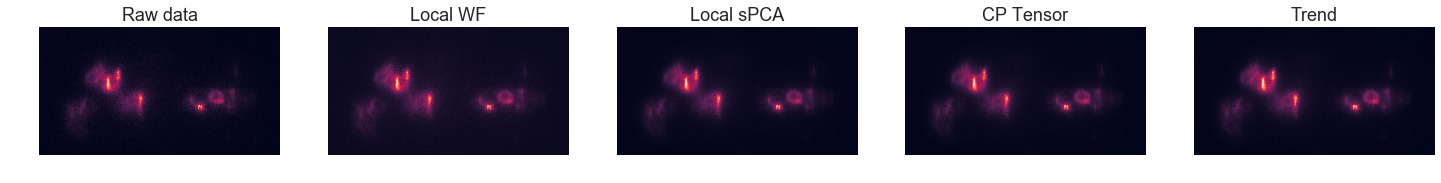

In [29]:
f, ax = plt.subplots(1, len(tmp_), figsize=(25, 5))
for nPlt in range(len(tmp_)):
    cf = ax[nPlt].imshow(tmp_[nPlt][:, :, 0])
    ax[nPlt].set_title(titles[nPlt])
    ax[nPlt].axis('off')
plt.show()

In [30]:
from utils.video import videoWrite
for im, mov in zip(tmp_, movie_):
    videoWrite(im, mov+'.mp4', axis=-1)

### A.2 SNR

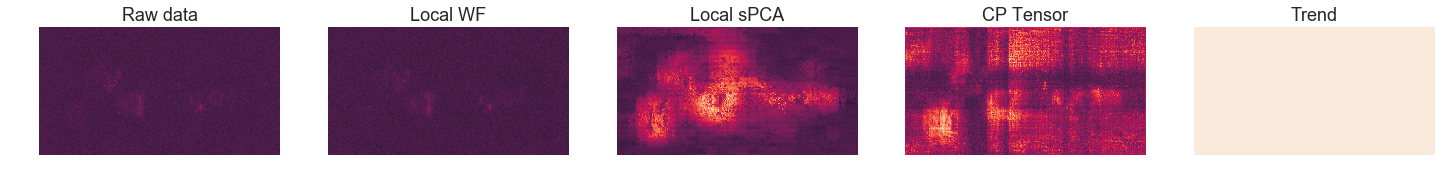

In [37]:
f, ax = plt.subplots(1, len(tmp_), figsize=(25, 5))
for nPlt in range(len(tmp_)):
    Y_ = tmp_[nPlt]
    mean_ = Y_.mean(axis=2,keepdims=True)
    sn, psdx =cm.source_extraction.cnmf.pre_processing.get_noise_fft(Y_ - mean_,noise_method='logmexp')
    SNR_ = Y_.var(2)/sn**2
    cf = ax[nPlt].imshow(np.log(SNR_), vmin=0.1, vmax=2.5)
    ax[nPlt].set_title(titles[nPlt])
    ax[nPlt].axis('off')
plt.show()

### A.3 Local correlations

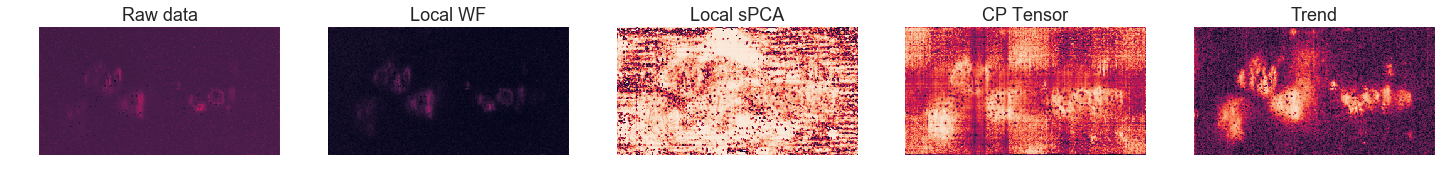

In [38]:
f, ax = plt.subplots(1, len(tmp_), figsize=(25, 5))
for nPlt in range(len(tmp_)):
    Y_ = tmp_[nPlt]
    cf = ax[nPlt].imshow(np.abs(cm.local_correlations(Y_)), vmin=0, vmax=1)
    ax[nPlt].set_title(titles[nPlt])
    ax[nPlt].axis('off')
plt.show()

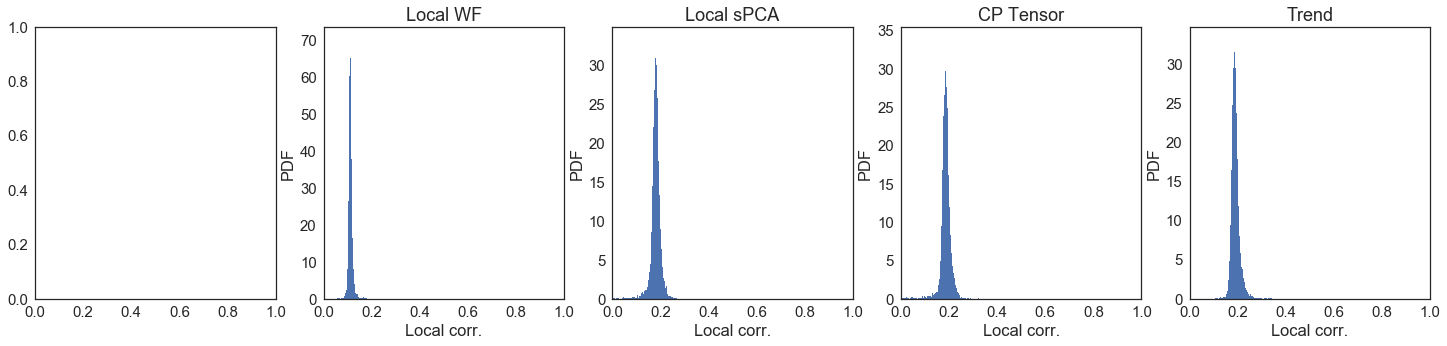

In [45]:
f, ax = plt.subplots(1, len(tmp_), figsize=(25, 5))
for nPlt in range(1, len(tmp_)):
    Y_ = tmp_[nPlt]
    cf = ax[nPlt].hist(np.abs(cm.local_correlations(Y_ - Y)).reshape(-1), 1000, density=True)
    ax[nPlt].set_title(titles[nPlt])
    ax[nPlt].set_xlim([0,1])
    ax[nPlt].set_xlabel('Local corr.')
    ax[nPlt].set_ylabel('PDF')
plt.show()